In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Conv2D, Dense, BatchNormalization
from keras.layers import Flatten, MaxPooling2D, Activation
from keras.layers import InputLayer, Input, SpatialDropout2D 
from keras.layers import RandomFlip, RandomZoom, RandomRotation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
data = np.load('flatland_train.npz')
X = data['X']
y = data['y'].astype(int)

y[y != 0] -= 2    # Correct labels so that triangle is mapped to class 1
X = X / 255.      # Scale down to range [0, 1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

# Multiple different models

## First model
A couple of convolutional layers as well as a MaxPooling layer.

In [ ]:
def create_model():
  model = keras.models.Sequential()
  model.add(InputLayer(input_shape=[50, 50, 1]))

  model.add(Conv2D(128, kernel_size=(5, 5), strides=2))
  model.add(BatchNormalization())
  model.add(Activation("relu"))

  model.add(Conv2D(64, kernel_size=(3, 3)))
  model.add(BatchNormalization())
  model.add(Activation("relu"))

  model.add(MaxPooling2D(pool_size=(4, 4)))

  model.add(Conv2D(64, kernel_size=(3, 3)))
  model.add(BatchNormalization())
  model.add(Activation("relu"))

  model.add(Conv2D(64, kernel_size=(3, 3)))
  model.add(BatchNormalization())
  model.add(Activation("relu"))


  model.add(BatchNormalization())

  # Dense layers
  model.add(Flatten())
  model.add(Dense(1000, activation="relu"))
  model.add(keras.layers.Dropout(0.2))
  model.add(Dense(1000, activation="relu"))
  model.add(Dense(5, activation="softmax"))
  model.compile(loss="sparse_categorical_crossentropy",
                optimizer='sgd',
                metrics=["accuracy"])

  return model

## Second model
Imitation of Lenet-5 architecture. Has very few weights and a fairly low accuracy.

In [ ]:
def create_model():
  model = keras.models.Sequential()
  model.add(InputLayer(input_shape=[50, 50, 1]))
  model.add(Conv2D(6, kernel_size=(5, 5)))
  model.add(BatchNormalization())
  model.add(Activation("tanh"))
  
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  model.add(Conv2D(16, kernel_size=(5, 5)))
  model.add(BatchNormalization())
  model.add(Activation("tanh"))

  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  model.add(Conv2D(120, kernel_size=(5, 5)))
  model.add(BatchNormalization())
  model.add(Activation("tanh"))

  model.add(BatchNormalization())

  # Dense layers
  model.add(Flatten())
  model.add(Dense(84, activation="tanh"))
  model.add(keras.layers.Dropout(0.4))
  model.add(Dense(5, activation="softmax"))
  model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Adam(3e-4),
                metrics=["accuracy"])

  return model

## Third model
Added RandomRotation and SpatialDropout layers: the first rotates images randomly during training while the other works like regular dropout, except it deactivates some filters from convolutional layers during training. Reduced number of weights from other layers.

In [ ]:
def create_model():
  inp = Input(shape=(50, 50, 1))

  # Random augmentation layers
  out = RandomRotation(factor=0.5, fill_mode='constant')(inp)

  # Convolutional layers
  out = Conv2D(64, kernel_size=(7, 7), strides=2, activation='relu')(out)
  out = BatchNormalization()(out)
  out = SpatialDropout2D(0.2)(out)

  out = Conv2D(64, kernel_size=(5, 5), activation='relu')(out)
  out = BatchNormalization()(out)
  out = SpatialDropout2D(0.2)(out)

  out = MaxPooling2D(pool_size=(2, 2))(out)

  out = Conv2D(64, kernel_size=(3, 3), activation='relu')(out)
  out = BatchNormalization()(out)

  out = MaxPooling2D(pool_size=(2, 2))(out)

  out = Conv2D(64, kernel_size=(3, 3), activation='relu')(out)
  out = BatchNormalization()(out)

  # Dense layers
  out = Flatten()(out)
  out = Dense(600, activation="relu")(out)
  out = keras.layers.Dropout(0.5)(out)
  out = Dense(5, activation="softmax")(out)
  
  model = Model(inputs=inp, outputs=out)
  model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=3e-4),
                metrics=["accuracy"])

  return model

## Fourth model
Switched some layers around. Added RandomZoom which should help improve accuracy on the advanced set. RandomFlip makes training 2 times longer for some reason and only helps a little bit so it was not included.

In [ ]:
def create_model():
  inp = Input(shape=(50, 50, 1))

  # Random augmentation layers
  out = RandomRotation(factor=0.5, fill_mode='constant')(inp)
  out = RandomZoom((-0.3, 0.3), (-0.3, 0.3), fill_mode='constant')(out)
  #out = RandomFlip()(out)

  # Convolutional layers
  out = Conv2D(64, kernel_size=(7, 7), strides=2, activation='relu')(out)
  out = BatchNormalization()(out)
  out = SpatialDropout2D(0.2)(out)
  
  out = Conv2D(128, kernel_size=(5, 5), activation='relu')(out)
  out = BatchNormalization()(out)
  out = SpatialDropout2D(0.2)(out)

  out = MaxPooling2D(pool_size=(3, 3))(out)

  out = Conv2D(64, kernel_size=(3, 3), activation='relu')(out)
  out = BatchNormalization()(out)

  out = Conv2D(32, kernel_size=(3, 3), activation='relu')(out)
  out = BatchNormalization()(out)

  # Dense layers
  out = Flatten()(out)
  out = Dense(512, activation="relu")(out)
  out = keras.layers.Dropout(0.5)(out)
  out = Dense(5, activation="softmax")(out)
  
  model = Model(inputs=inp, outputs=out)
  model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=3e-4),
                metrics=["accuracy"])

  return model

# Training and evaluation

In [ ]:
model = create_model()
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 50, 50, 1)]       0         
                                                                 
 random_rotation_7 (RandomRo  (None, 50, 50, 1)        0         
 tation)                                                         
                                                                 
 random_zoom_6 (RandomZoom)  (None, 50, 50, 1)         0         
                                                                 
 conv2d_35 (Conv2D)          (None, 22, 22, 64)        3200      
                                                                 
 batch_normalization_37 (Bat  (None, 22, 22, 64)       256       
 chNormalization)                                                
                                                                 
 spatial_dropout2d_20 (Spati  (None, 22, 22, 64)       0   

In [ ]:
loss = model.fit(X_train, y_train, batch_size=16, epochs=20, 
                 validation_data=(X_test, y_test))

Epoch 1/20
375/375 [==============================] - 3s 8ms/step - loss: 0.1760 - accuracy: 0.9598 - val_loss: 0.1298 - val_accuracy: 0.9845
Epoch 2/20
375/375 [==============================] - 2s 7ms/step - loss: 0.1743 - accuracy: 0.9610 - val_loss: 0.1257 - val_accuracy: 0.9845
Epoch 3/20
375/375 [==============================] - 2s 6ms/step - loss: 0.1655 - accuracy: 0.9642 - val_loss: 0.1304 - val_accuracy: 0.9843
Epoch 4/20
375/375 [==============================] - 2s 7ms/step - loss: 0.1725 - accuracy: 0.9615 - val_loss: 0.1332 - val_accuracy: 0.9843
Epoch 5/20
375/375 [==============================] - 3s 7ms/step - loss: 0.1646 - accuracy: 0.9663 - val_loss: 0.1311 - val_accuracy: 0.9843
Epoch 6/20
375/375 [==============================] - 3s 7ms/step - loss: 0.1676 - accuracy: 0.9637 - val_loss: 0.1295 - val_accuracy: 0.9843
Epoch 7/20
375/375 [==============================] - 2s 7ms/step - loss: 0.1680 - accuracy: 0.9662 - val_loss: 0.1288 - val_accuracy: 0.9845
Epoch 

In [ ]:
pd.DataFrame(loss.history).plot()

## Data with correct values
There are 148 incorrect values in the data set. These values do not seem to affect the models performance too much and I only used them to train the final model and test for true accuracy.

In [ ]:
y_true = y.copy()
input = np.array([19, 399, 436, 473, 505, 563, 597, 619, 679, 696, 756, 760, 
                  1238, 1403, 1409, 1413, 1442, 1467, 1474, 1598, 1748, 1854,
                  1975, 2105, 2148, 2183, 2225, 2226, 2281, 2345, 2419, 2601,
                  2676, 2721, 2748, 2752, 2813, 2978, 2980, 3029, 3092, 3110,
                  3143, 3249, 3276, 3357, 3431, 3441, 3798, 3802, 3809, 3853, 
                  3894, 3896, 3988, 4006, 4025, 4037, 4063, 4068, 4094, 4115,
                  4168, 4243, 4273, 4294, 4402, 4452, 4484, 4488, 4645, 4659,
                  4759, 4804, 4816, 4907, 4980, 5034, 5045, 5056, 5061, 5083,
                  5130, 5333, 5375, 5423, 5515, 5571, 5846, 5859, 5887, 5909,
                  5965, 5996, 6006, 6045, 6068, 6131, 6155, 6162, 6222, 6317,
                  6376, 6384, 6452, 6517, 6559, 6653, 6670, 6674, 6679, 6776,
                  6942, 7008, 7093, 7107, 7129, 7220, 7338, 7490, 7557, 7575,
                  7601, 7655, 7806, 7908, 7956, 7983, 8068, 8189, 8360, 8585,
                  8613, 8631, 8635, 8724, 8919, 9089, 9197, 9344, 9495, 9566,
                  9591, 9664, 9687, 9704, 9718, 9839])
output = np.array([4, 4, 4, 5, 5, 4, 3, 4, 6, 0, 5, 0, 3, 3, 6, 4, 3, 6, 3, 0, 
                   4, 5, 4, 3, 4, 5, 5, 6, 0, 3, 5, 5, 3, 6, 5, 6, 6, 3, 5, 0, 
                   6, 0, 5, 6, 4, 4, 3, 6, 3, 6, 4, 0, 5, 5, 3, 4, 5, 6, 3, 4,
                   5, 3, 0, 3, 6, 6, 0, 5, 3, 6, 5, 3, 5, 4, 3, 5, 3, 5, 3, 3,
                   0, 3, 3, 6, 5, 6, 4, 3, 5, 5, 0, 3, 0, 5, 6, 5, 5, 4, 0, 6, 
                   3, 4, 4, 4, 0, 4, 5, 6, 3, 0, 3, 5, 3, 0, 0, 3, 4, 3, 0, 0,
                   6, 6, 0, 0, 3, 6, 3, 0, 4, 4, 4, 6, 3, 6, 0, 3, 6, 5, 0, 5,
                   0, 3, 4, 3, 3, 4, 0, 6])
output[output != 0] -= 2

y_true[input] = output

## Evaluation

In [ ]:
pred = model.predict(X).argmax(axis=1)
failures = X[pred != y_true]
index = np.arange(0, len(y_true))[pred != y_true]
print(f'Accuracy: {model.evaluate(X, y_true)[1]}')

313/313 [==============================] - 1s 4ms/step - loss: 0.0060 - accuracy: 0.9996
Accuracy: 0.9995999932289124


In [ ]:
failures.shape

(4, 50, 50)

In [ ]:
names = ['circle', 'triangle', 'square', 'pentagon', 'hexagon']
pd.DataFrame(confusion_matrix(y_true, pred), index=names, columns=names).style.background_gradient(axis=None)

,circle,triangle,square,pentagon,hexagon
circle,1375,0,0,1,0
triangle,0,2866,0,0,0
square,0,0,1866,0,0
pentagon,0,0,0,2138,0
hexagon,0,0,0,3,1751


Hexagons are often confused with pentagons and circles. This makes sense since the model has to accurately count all the vertices which can be difficult.

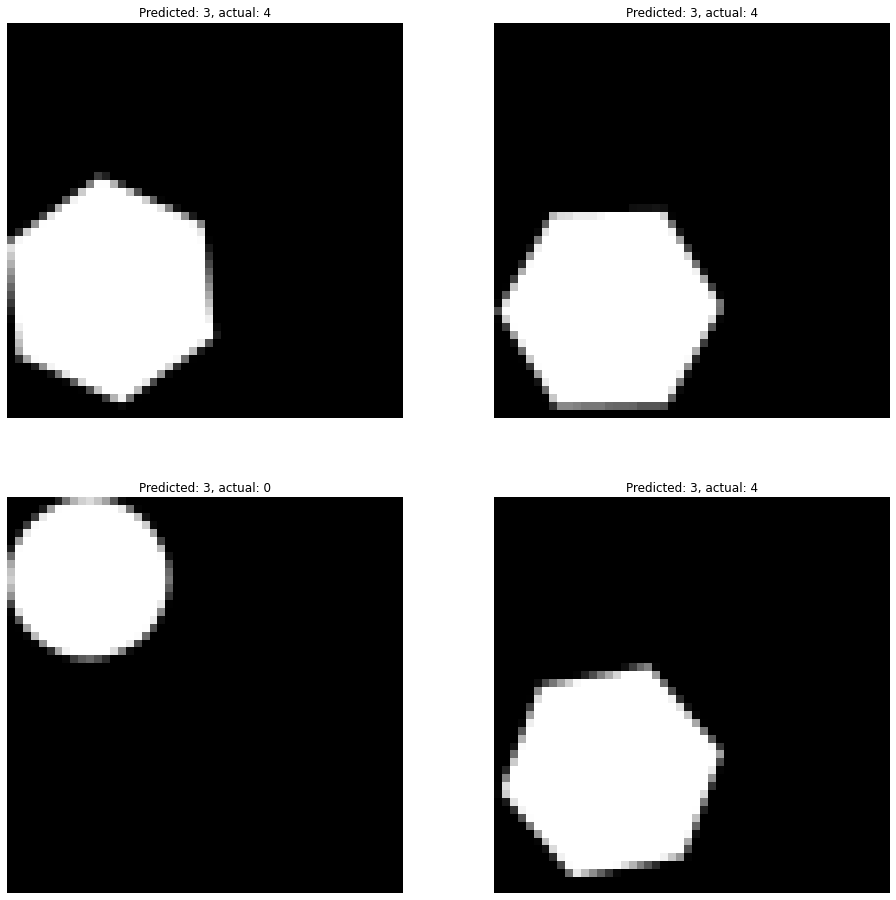

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

for i,ax in enumerate(axes.flat):
    ax.imshow(failures[i], cmap='gray')
    ax.set_axis_off()
    ax.set_title(f'Predicted: {pred[index[i]]}, actual: {y_true[index[i]]}')

## Visualization

In [ ]:
# Fourth model after first convolution layer 
# (without the augmentation layers)
x = X[..., None]
x = model.layers[3](x)

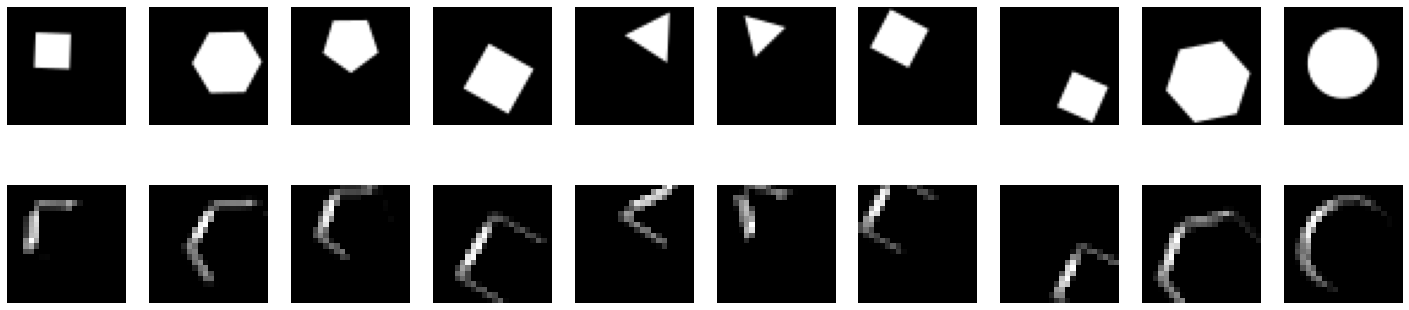

In [ ]:
# First 10 images after first convolutional layer in fourth model
fig, axes = plt.subplots(2, 10, figsize=(25, 6))
filter_num = 16

for i, ax in enumerate(axes[:].T):
  ax[0].imshow(X[i], cmap='gray')
  ax[0].set_axis_off()

  ax[1].imshow(x[i, ..., filter_num], cmap='gray')
  ax[1].set_axis_off()

## Saliency

In [ ]:
def saliency(model, single_input):
    single_input = tf.convert_to_tensor(single_input, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(single_input)
        predictions = model(single_input)
        winning_class, = tf.argmax(predictions, axis=1)
        output = predictions[:, winning_class]

    # Gradients of the loss with respect to the input
    gradient = tape.gradient(output, single_input)

    return np.abs(gradient)

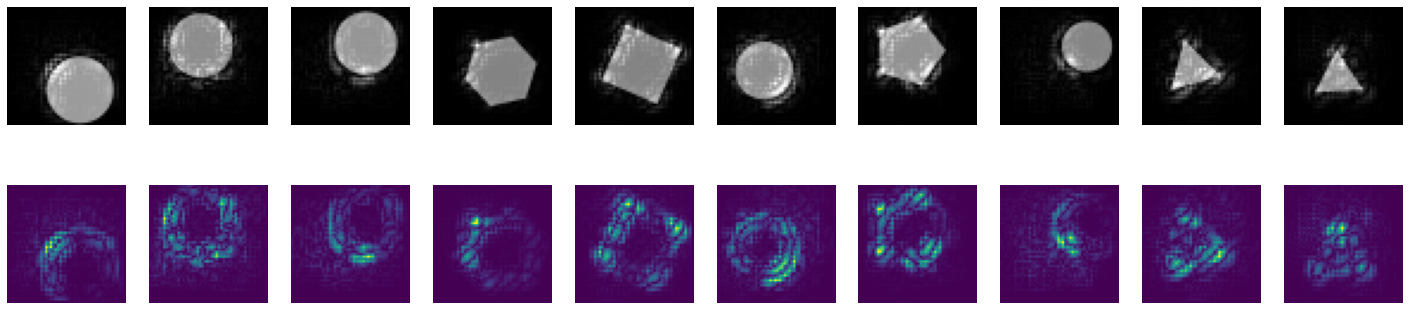

In [ ]:
# Which parts of the images have the biggest impact on the predicted class

fig, axes = plt.subplots(2, 10, figsize=(25, 6))
num = 3
for i, ax in enumerate(axes[:].T):
  X_new = saliency(model, X[10*num+i, None])[0]
  ax[0].imshow(0.5*X[10*num+i] + 0.5*X_new/X_new.max(), cmap='gray')
  ax[0].set_axis_off()

  ax[1].imshow(X_new)
  ax[1].set_axis_off()

# Transfer learning (failed)

In [ ]:
mobile_net = keras.applications.MobileNet(weights='imagenet', include_top=False,
                                          input_shape=(50, 50, 3))

mobile_net.trainable = False
    
inp = keras.layers.Input(shape=(50, 50, 3))
embedding = mobile_net(inp, training=False)
out = keras.layers.Flatten()(embedding)
out = keras.layers.Dense(5, activation='softmax')(out)
model = keras.models.Model(inputs=inp, outputs=out)
model.summary()

model.compile(optimizer='sgd', loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

17225924/17225924 [==============================] - 2s 0us/step
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 50, 50, 3)]       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 1024)              0         
                                                                 
 dense_21 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 3,233,989
Trainable params: 5,125
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
X_new_train = np.repeat(X_train[..., None], 3, axis=3)
X_new_test = np.repeat(X_test[..., None], 3, axis=3)

In [ ]:
model.fit(X_new_train, y_train, validation_data=(X_new_test, y_test), batch_size=16, 
          epochs=30)

Epoch 1/30
375/375 [==============================] - 5s 10ms/step - loss: 1.4200 - accuracy: 0.4362 - val_loss: 1.3091 - val_accuracy: 0.5002
Epoch 2/30
375/375 [==============================] - 3s 8ms/step - loss: 1.2526 - accuracy: 0.5220 - val_loss: 1.2122 - val_accuracy: 0.5357
Epoch 3/30
375/375 [==============================] - 3s 7ms/step - loss: 1.1786 - accuracy: 0.5518 - val_loss: 1.1615 - val_accuracy: 0.5575
Epoch 4/30
375/375 [==============================] - 3s 8ms/step - loss: 1.1349 - accuracy: 0.5672 - val_loss: 1.1288 - val_accuracy: 0.5655
Epoch 5/30
375/375 [==============================] - 3s 7ms/step - loss: 1.1041 - accuracy: 0.5848 - val_loss: 1.1023 - val_accuracy: 0.5785
Epoch 6/30
375/375 [==============================] - 3s 7ms/step - loss: 1.0803 - accuracy: 0.5878 - val_loss: 1.0873 - val_accuracy: 0.5922
Epoch 7/30
375/375 [==============================] - 3s 8ms/step - loss: 1.0620 - accuracy: 0.5940 - val_loss: 1.0684 - val_accuracy: 0.5870
Epoch

# Conclusion
The best performing models were those that augmented the images during training. It seems that if the model has very few weights, the accuracy varies a lot whereas if there are a lot of weights, it is difficult for the model to find the global minimum of the cost function and it is also more susceptible to overfitting. The fourth model could probably be improved if more general linear transformations of the images were considered during training.